## Diversity Sampling of Wikipedia Articles

This notebook provides a demo of the Coreset sampler, applied to text embeddings. 
The coreset algorithm iteratively samples the furthest texts to all the previously sampled texts, ensuring diversity.




**Notes**: We recommend running it on GPU. If you don't have access to a GPU, subsampling the data may be necessary



## Initialization

In [25]:
# cd ../src

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [3]:
import torch
torch.cuda.is_available()  # Code is faster on GPU !

True

In [4]:
import sys
sys.path.append('../src/')

from coreset import CoresetSampler
from plot import plot_dbscan_results, plot_coreset_results

### Retrieve data

The dataset is a preprocessed subset from [here](https://www.kaggle.com/datasets/narek1110/wikipedia-22-12-en-embeddings-all-minilm-l6-v2). 

- **df.parquet** : contains articles & associated metadata
    - `id`: article id
    - `title`: Title of the article
    - `text`: First paragraph of the article.
    - `url`: Url of the article
    - `domain`: Predicted domain by a [this 10-class](https://huggingface.co/jonaskoenig/topic_classification_04) classifier.
    - `bertopic_class`: Predict class by [BERTopic](https://huggingface.co/MaartenGr/BERTopic_Wikipedia)
- **embeds.npy** : Embeddings assoaited to the `text` column, computed using [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [5]:
df = pd.read_parquet('../input/df_2.parquet')
print(f"Retrieved {len(df)} articles")

Retrieved 486826 articles


In [6]:
embeds = np.load('../input/embeds.npy')
print(f"Embedding shape: {embeds.shape}")

Embedding shape: (486826, 384)


### Coreset Sampler

The class `CoresetSampler` defined in `coreset.py` does all the heavy lifting !

I also define some parameters:
- `EPS`, `MIN_SAMPLES` are DBScan initialization parameters that work well for the provided data. 
- `N_SAMPLES` is the number of points we want to sample with coreset.

In [7]:
EPS = 0.85  # Higher eps = bigger clusters
MIN_SAMPLES = 100
N_SAMPLES = 1000

In [8]:
coreset = CoresetSampler(
    n_samples=N_SAMPLES,
    initialization="dbscan",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=False,
    verbose=1,
)

### DBScan Initialization

We run DBScan clustering and analyze the results.

It takes about 1 minute to run DBScan on our data, provided that you have a GPU.

In [9]:
%%time
init_ids = coreset.initialize(embeds)

Using cuml gpu-accelerated algorithms
Initializing with DBScan
[W] [14:52:01.949860] Batch size limited by the chosen integer type (4 bytes). 10892 -> 4411. Using the larger integer type might result in better performance
Initialize with 36 points
CPU times: user 1min 12s, sys: 1.04 s, total: 1min 14s
Wall time: 1min 13s


In [10]:
y = coreset.dbscan_y
counts = np.bincount(y + 1)

In [11]:
print('Number of clusters :', len(counts) - 1)
print('Number of non-clustered prompts :', counts[0])

Number of clusters : 36
Number of non-clustered prompts : 460123


In [12]:
biggest = np.argsort(counts[1:])[::-1] # [:10]
sizes = np.sort(counts[1:])[::-1]
print('Biggest clusters :\t', list(biggest[:10]))
print('Associated sizes :\t', list(sizes[:10]))

Biggest clusters :	 [0, 4, 10, 28, 17, 18, 5, 6, 11, 15]
Associated sizes :	 [11717, 2601, 1610, 941, 837, 734, 681, 557, 503, 458]


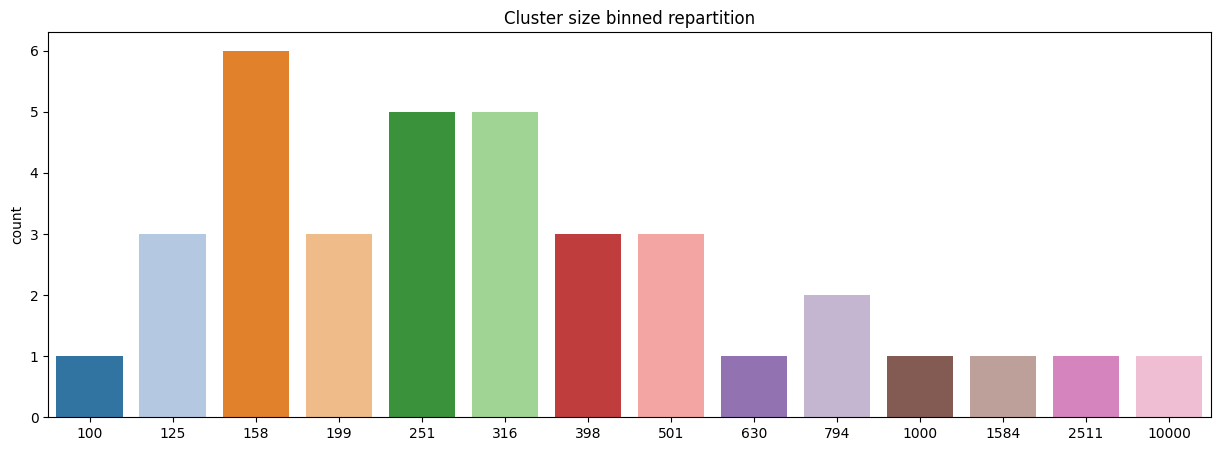

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(x=np.round(np.log10(np.clip(counts[1:], 0, 10000)), 1))
ticks, labels = plt.xticks()
labels = [float(l.get_text()) for l in labels]
plt.xticks(ticks, (10 ** np.array(labels)).astype(int))
plt.title('Cluster size binned repartition')
plt.show()

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


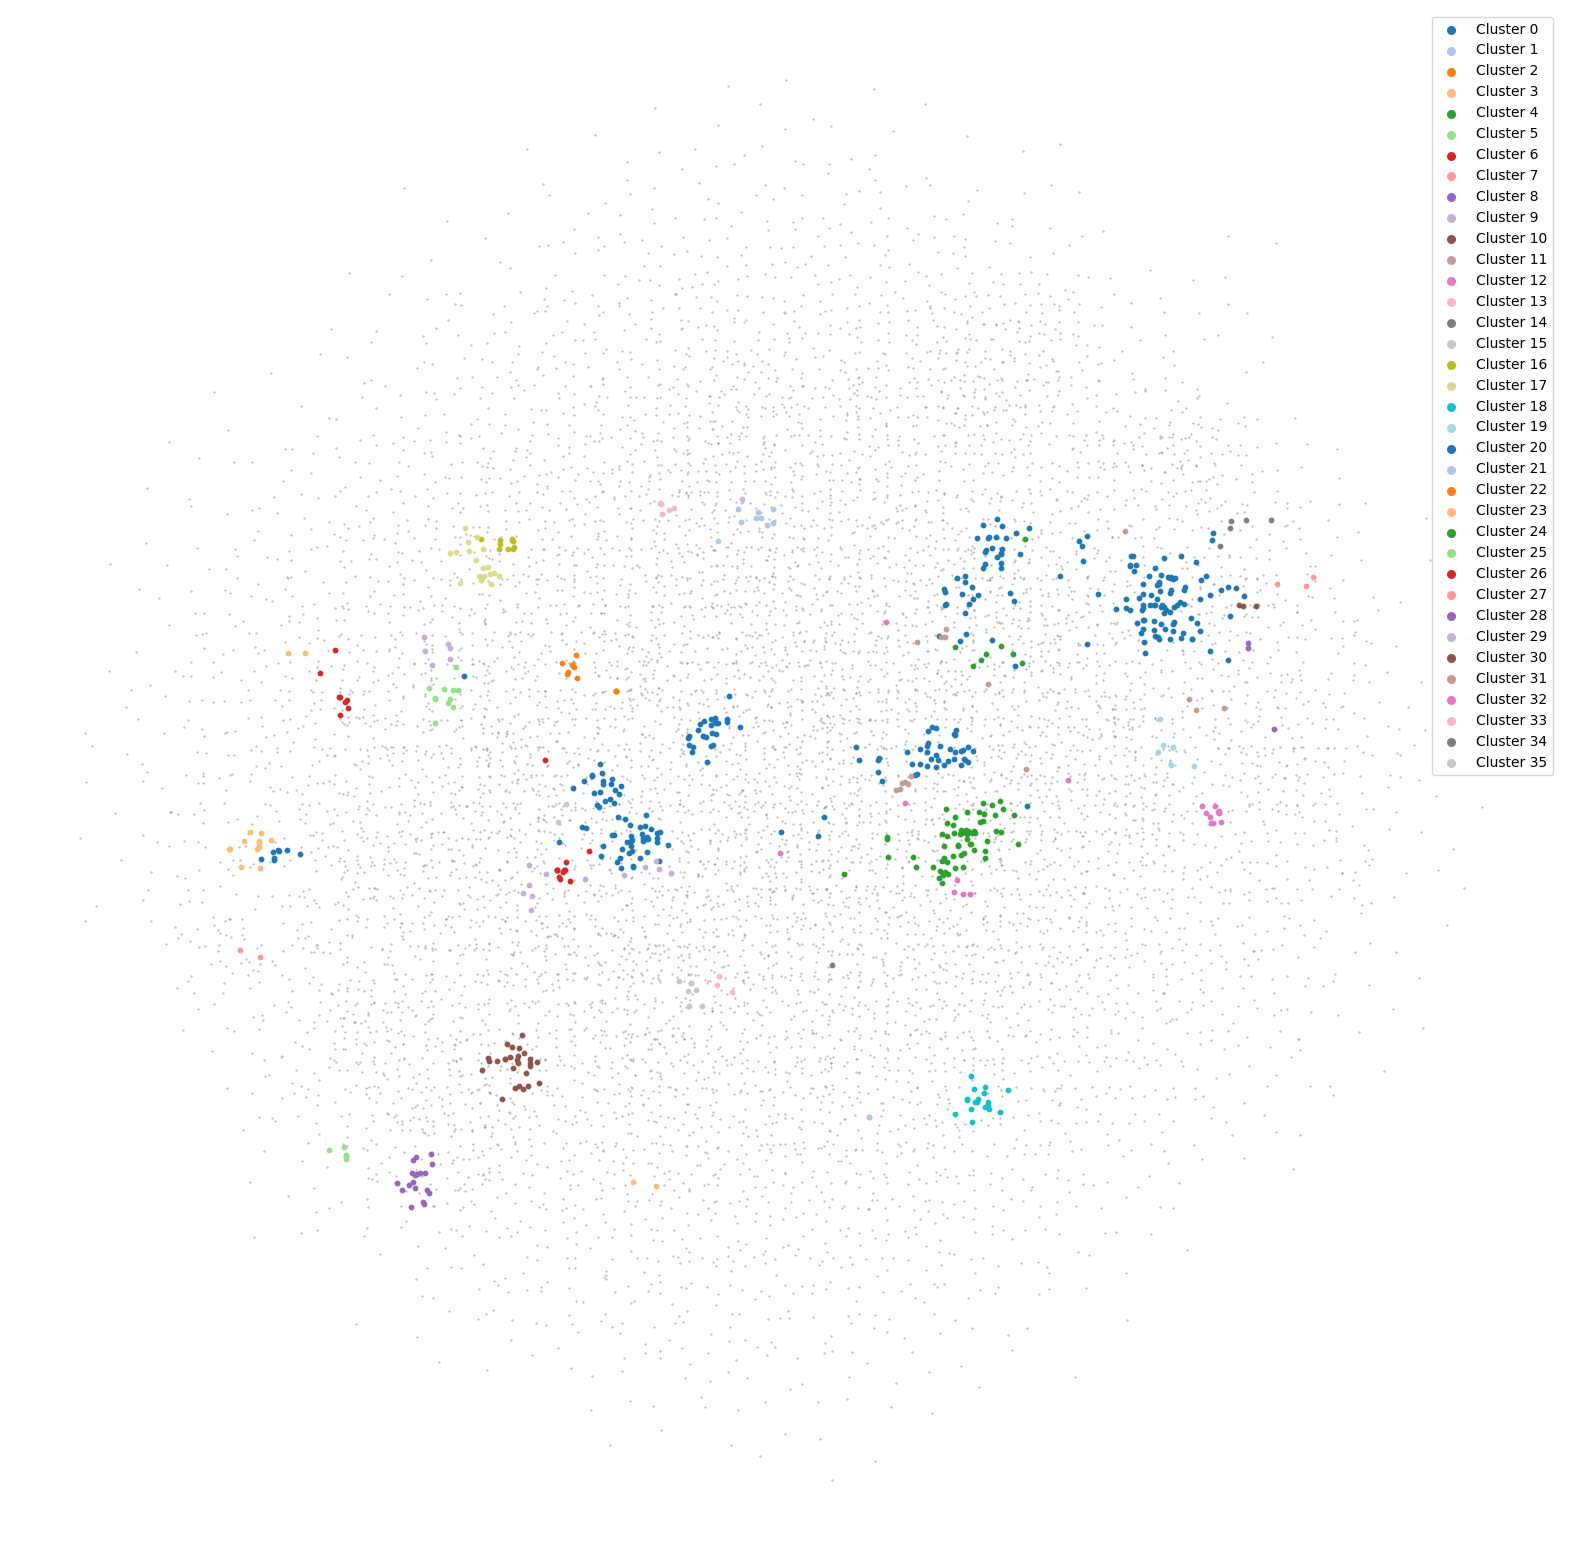

In [28]:
plot_dbscan_results(
    embeds, 
    y,
    counts,
    min_size=MIN_SAMPLES, 
    tsne_params=dict(perplexity=10, early_exaggeration=10),
)

The `plot_dbscan_results` function uses t-SNE to visualize DBScan results. Clusters are highlighted and outliers are in gray. 
The sampler will initialize using one random point per cluster.

We display below are a sample of the 10 biggest clusters :

In [27]:
for i, l in enumerate(np.argsort(counts)[::-1][:10]):
    l -= 1
    if l == -1:
        continue
        
    if counts[l + 1] <= MIN_SAMPLES:
        continue

    ids = np.where(y == l)[0]

    print("Cluster id :", l)
    print("Cluster size :", len(ids))
    display(df[['title', 'text']].iloc[ids].sample(5))  # min(5, len(ids))))

    print('-' * 100)

    # if i > 1:
    #     break

Cluster id : 0
Cluster size : 11717


,title,text
325720,Kulunda (river),"The basin of the river is located in the Rebrikhinsky, Tyumentsevsky, Bayevsky and Blagoveshchensky districts. There are a number of villages near its banks, such as Bayevo, Pokrovka, Kapustinka, Proslaukha and Gryaznovo."
327211,Karśnice,"Karśnice is a village in the administrative district of Gmina Śmigiel, within Kościan County, Greater Poland Voivodeship, in west-central Poland. It lies approximately north of Śmigiel, west of Kościan, and south-west of the regional capital Poznań."
136178,Dmitri Anatolyevich Kuznetsov,"Dmitri Anatolyevich Kuznetsov (; born 14 August 1972, died 1 July 2021) was a Russian professional footballer."
131996,Kyrgyzstan at the 2014 Summer Youth Olympics,"Kyrgyzstan competed at the 2014 Summer Youth Olympics, in Nanjing, China from 16 August to 28 August 2014."
271582,Piermaria Siciliano,"Piermaria Siciliano (born 27 June 1974, in Catania) is a retired freestyle swimmer from Italy, who represented his native country at two consecutive Summer Olympics: 1992 and 1996. He won the bronze medal in the men's 4×200 m freestyle at the 1995 European Aquatics Championships, alongside Massimiliano Rosolino, Emanuele Merisi, and Emanuele Idini."


----------------------------------------------------------------------------------------------------
Cluster id : 4
Cluster size : 2601


,title,text
147866,Ramón Fernando García,"Ramón Fernando García (born March 15, 1972 in El Carmen, Santander) is a retired male professional road racing cyclist from Colombia."
322610,Luis Zuñiga,Luis Zuñiga (born 4 July 1939) is a Chilean boxer. He competed in the men's lightweight event at the 1964 Summer Olympics.
2428,René Lima,"René Martín Lima (born 3 January 1985 in Vicente López, Buenos Aires) is an Argentine footballer, who plays as a midfielder for Comunicaciones."
281389,Renato Espinosa,Renato Espinosa Torres (born 6 July 1998) is a Peruvian footballer who plays as a forward for Peruvian Primera División side Deportivo Municipal.
486109,José Argumedo,José Eduardo Argumedo Barraza (born 14 October 1988) is a Mexican professional boxer who held the IBF mini flyweight title from 2015 to 2017.


----------------------------------------------------------------------------------------------------
Cluster id : 10
Cluster size : 1610


,title,text
194284,Leptomyrina makala,Leptomyrina makala is a butterfly in the family Lycaenidae. It is found in Kivu in the Democratic Republic of the Congo and in western Uganda.
136095,Dichelopa meligma,Dichelopa meligma is a species of moth of the family Tortricidae. It is found on the Marquesas Archipelago in French Polynesia.
166120,Elachista ragnorella,"Elachista ragnorella is a moth of the family Elachistidae. It is found in the United States, where it has been recorded from Colorado."
121597,Bryotropha domestica,"Bryotropha domestica is a moth of the family Gelechiidae. It is found from Ireland to Germany, Slovakia, Romania and Bulgaria and from the Benelux to the Iberian Peninsula, Sicily, Crete and Cyprus. It is also found in Morocco, Algeria, Tunisia, Libya, the Middle East, Turkmenistan, Saudi Arabia and Yemen."
191473,Hyposmocoma uhauiole,"Hyposmocoma uhauiole is a species of moth of the family Cosmopterigidae. It is endemic to Kauai. The species belongs to the amphibious caterpillar guild of the genus ""Hyposmocoma""."


----------------------------------------------------------------------------------------------------
Cluster id : 28
Cluster size : 941


,title,text
51501,Echinolittorina philippinensis,"Echinolittorina philippinensis, is a species of sea snail, a marine gastropod mollusk in the family Littorinidae, the winkles or periwinkles."
192527,Bithynia bavelensis,"Bithynia bavelensis is an extinct species of freshwater snail with gills and an operculum, an aquatic prosobranch gastropod mollusk in the family Bithyniidae."
45947,Conus cervus,"Conus cervus, common name the pallisade cone, is a species of sea snail, a marine gastropod mollusk in the family Conidae, the cone snails and their allies."
194430,Letourneuxia nyctelia,"Letourneuxia nyctelia is a species of terrestrial slug, a gastropod mollusc, belonging to the family Arionidae."
199322,Hyalina pallida,"Hyalina pallida is a species of sea snail, a marine gastropod mollusk in the family Marginellidae, the margin snails."


----------------------------------------------------------------------------------------------------
Cluster id : 17
Cluster size : 837


,title,text
364279,KULH,"KULH is a radio station airing a format consisting of Christian contemporary music and Christian talk and teaching, licensed to Wheeling, Missouri, broadcasting on 105.9 MHz FM. The station serves the areas of Brookfield, Missouri and Chillicothe, Missouri, and is owned by Resources Management Unlimited, Inc."
370321,KHEW,"KHEW 88.5 FM is a Community radio station, owned and operated by the Chippewa Cree Tribe of the Rocky Boy's Reservation. The station is licensed to the Rocky Boy's Reservation in Montana."
190330,KTGB-LP,"KTGB-LP was a low-power television station affiliated with The Inspiration Network, operating on UHF channel 26 in Lubbock, Texas. The station owner was Jennifer Cremeens of Creemeens Broadcasting."
466510,KKTZ,"KKTZ (107.5 FM) is a radio station airing a hot adult contemporary format licensed to Mountain Home, Arkansas. The station serves the areas of Mountain Home, Arkansas, Branson, Missouri, Harrison, Arkansas, and West Plains, Missouri, and is owned by Mac Partners."
319454,WZNC-LP,"WZNC-LP (99.9 FM, ""NCCR - North Country Community Radio"") is a radio station licensed to serve the community of Bethlehem, New Hampshire. The station is owned by Friends of the Colonial and airs a variety format."


----------------------------------------------------------------------------------------------------
Cluster id : 18
Cluster size : 734


,title,text
366730,2006 Milton Keynes Council election,"The 2006 Milton Keynes Council election took place on 4 May 2006 to elect members of Milton Keynes Unitary Council in Buckinghamshire, England. One third of the council was up for election and the Liberal Democrats lost overall control of the council to no overall control."
80843,1969 Edinburgh Corporation election,"An Election to the Edinburgh Corporation was held on 6 May 1969, alongside municipal elections across Scotland. Of the councils 69 seats, 23 were up for election."
170398,1991 Waterford City Council election,An election to Waterford City Council took place on 27 June 1991 as part of that year's Irish local elections. 15 councillors were elected from three electoral divisions by PR-STV voting for a five-year term of office.
256158,1977 Strabane District Council election,Elections to Strabane District Council were held on 18 May 1977 on the same day as the other Northern Irish local government elections. The election used three district electoral areas to elect a total of 15 councillors.
313648,2006 Wigan Metropolitan Borough Council election,Elections to Wigan Council were held on 4 May 2006. One-third of the council was up for election and the Labour party kept overall control of the council. Overall turnout was 29.2%.


----------------------------------------------------------------------------------------------------
Cluster id : 5
Cluster size : 681


,title,text
141394,Minkiö railway station,"Minkiö railway station () is a neighborhood of the Kiipu village and a railway station at the Jokioinen Museum Railway, situated north of the Minkiö village on the northern shore of the river Jänhijoki, and on the western side of the Jänhijoki village in the municipality of Jokioinen. The neighborhood which developed around the railway station is located about eight kilometers from the center of Jokioinen and about eight kilometers from Humppila."
261368,Jinryō Station,"Jinryō Station is served by the Chūō Main Line, and is located 376.1 kilometers from the starting point of the line at Tokyo Station and 20.8 kilometers from Nagoya Station."
200256,Imayama Station,Imayama Station is served by the Hitahikosan Line and is located 65.4 km from the starting point of the line at . Services to the station are currently suspended due to damage from torrential rainfall.
95140,Sangen-Jaya Station,"Sangen-Jaya Station is served by the Tokyu Den-en-toshi Line, and also forms the terminus of the Tokyu Setagaya Line."
36282,Yumegaoka Station,"Yumegaoka Station is served by the Sagami Railway Izumino Line, and lies 9.3 kilometers from the starting point of the line at Futamatagawa Station."


----------------------------------------------------------------------------------------------------
Cluster id : 6
Cluster size : 557


,title,text
276183,Gudana,"As per 2011 census of India, it has a population of 2483, 1295 are males and 1188 females, in 504 families with an Average Sex Ratio of 917 and literacy rate of 78.53%."
118310,"Takata, Fukuoka","As of 2003, the town had an estimated population of 14,525 and a density of 354.18 persons per km². The total area was 41.01 km²."
460456,"Naganuma, Hokkaido","As of September 2016, the town has an estimated population of 11,262, and a density of 67 persons per km. The total area is 168.36 km."
264656,Leontica,"The municipality also contained the village Comprovasco. It had 315 inhabitants in 1602, which increased to 441 in 1808 and 473 in 1850. It then declined a bit, to 295 in 1900 and 408 in 1950. In 2000 the population had dropped to 267."
50792,"Hamatama, Saga","As of 2003, the town had an estimated population of 10,311 and a density of 197.79 persons per km. The total area was 52.13 km."


----------------------------------------------------------------------------------------------------
Cluster id : 11
Cluster size : 503


,title,text
154277,No Jae-wook,No Jae-wook (Hangul: 노재욱; born in Gwangju) is a South Korean male volleyball player. He is part of the South Korea men's national volleyball team. On club level he plays the setter position for Seoul Woori Card Wibee.
268824,Kim Jung-hyop,"Kim Jung-hyop (, born 1938) is a North Korean politician. He is a member of the Central Committee of the Workers' Party of Korea, head of the Party's Office of Documents and served as a member of the 13th convocation of the Supreme People's Assembly and director of the Documents Management Office of the Central Committee."
82073,Kim Min-sun (speed skater),Kim Min-sun (born 16 June 1999) is a South Korean speed skater. She won gold in the women's 500 metres event at the 2016 Winter Youth Olympics in Lillehammer and competed in the women's 500 metres at the 2018 Winter Olympics.
137350,Li Jong-hyong,Li Jong-hyong (born 3 January 1956) is a North Korean long-distance runner. He competed in the marathon at the 1980 Summer Olympics.
11255,Chung Pui Ki,"Chung Pui Ki (born 2 February 1998) is a Hongkonger footballer who plays as a defender for Hong Kong Women League club Kitchee SC. She is also a futsal player, and represented Hong Kong internationally in both football and futsal."


----------------------------------------------------------------------------------------------------


### Sampling

Apply the coreset algorithm, and show the results with t-SNE !

In [16]:
ids = coreset.sample(embeds)

100%|██████████| 964/964 [00:04<00:00, 194.65it/s]


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [14:53:28.422245] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


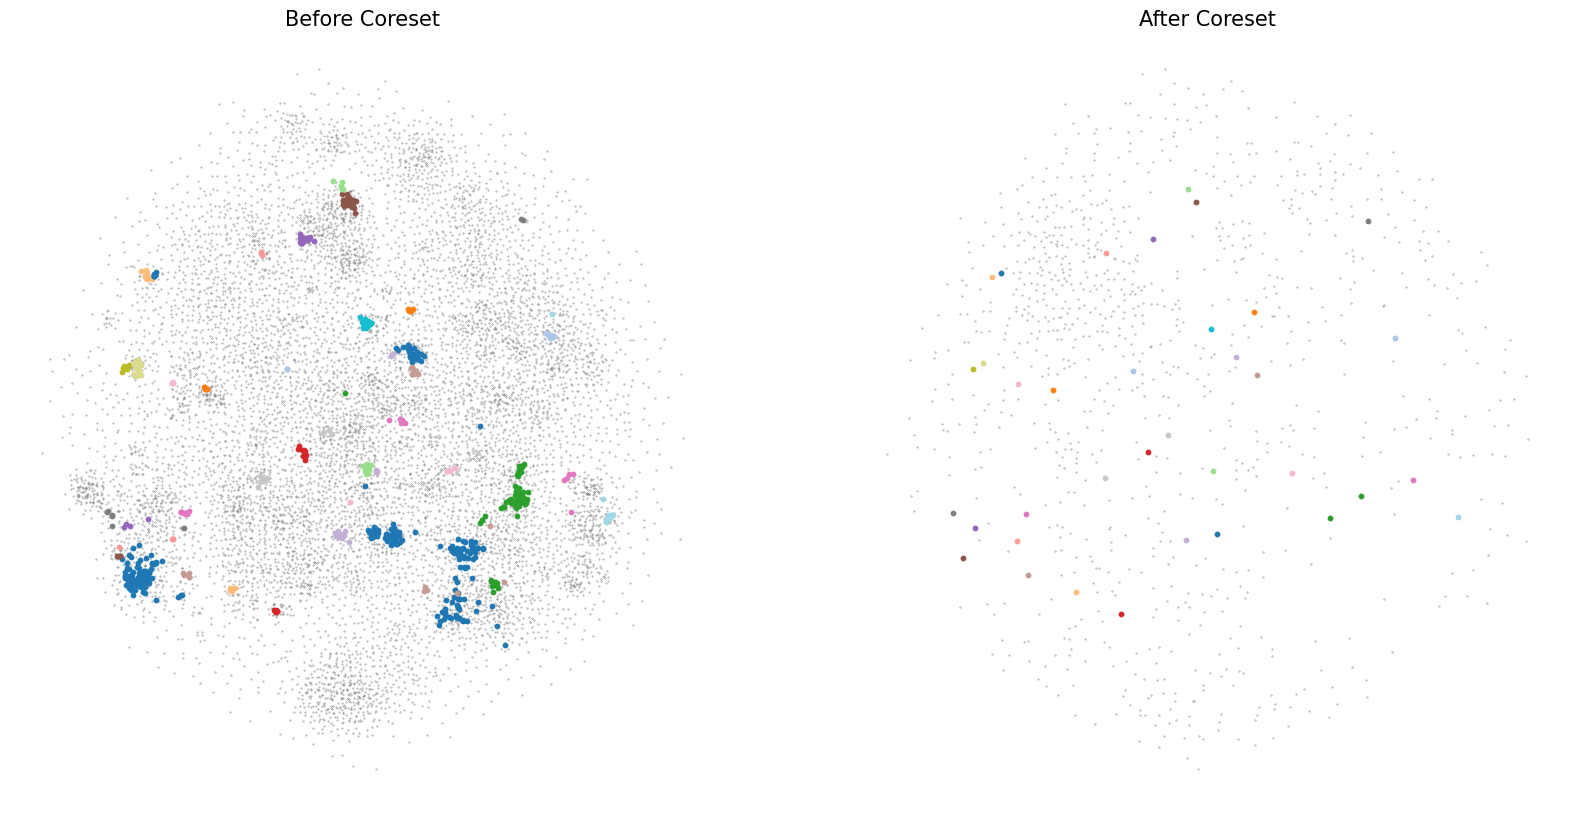

In [17]:
plot_coreset_results(
    embeds,
    y,
    counts,
    ids,
    min_size=MIN_SAMPLES,
    tsne_params=dict(perplexity=50, early_exaggeration=200),
)

## Compare with Random Sampling

To assess performance of the sampler, we provide two metrics that aim at demonstrating that the sampled data is more diverse than what you would get using random sampling.
The run the algorithm several times for more robustness, and do not use any initialization to save time.

- **Diversity**: We count the number of topics the sampled data contains and normalize it by its size. A higher value is better. The provided BERTopic classifier takes 2374 different values on our data.
- **KL Divergence**: Using a 27-class domain classifier, we aim at having a uniform sampling. This is assessed using the Kullback-Leibler divergence of the distribution of the sampled classes from the uniform distribution. A lower value is better.

In [18]:
N_TEXTS = [100, 500, 1000, 2000, 3000, 4000, 5000]  # Number of texts to sample

In [ ]:
len(df["bertopic_class"].unique())

2374

In [ ]:
coreset = CoresetSampler(
    initialization="",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=True,
    verbose=0,
)

In [ ]:
diversities_coreset = []
kl_divs_coreset = []
for n in N_TEXTS:
    diversities, kl_divs = [], []
    for _ in range(3):  # 3 -> 1 for faster execution
        sampled_ids = coreset.sample(embeds, n_samples=n)
        df_s = df.iloc[sampled_ids].reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)

        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_coreset.append(div)
    kl_divs_coreset.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  -  KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.970  -  KL Divergence 0.262
- n=500 	-  Diversity: 0.857  -  KL Divergence 0.260
- n=1000 	-  Diversity: 0.737  -  KL Divergence 0.294
- n=2000 	-  Diversity: 0.587  -  KL Divergence 0.295
- n=3000 	-  Diversity: 0.486  -  KL Divergence 0.302
- n=4000 	-  Diversity: 0.412  -  KL Divergence 0.309
- n=5000 	-  Diversity: 0.360  -  KL Divergence 0.320


In [ ]:
diversities_random = []
kl_divs_random = []
for n in N_TEXTS:
    diversities = []
    kl_divs = []
    for _ in range(10):
        df_s = df.sample(n).reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)
                
        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_random.append(div)
    kl_divs_random.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  - KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.877  - KL Divergence 0.297
- n=500 	-  Diversity: 0.657  - KL Divergence 0.405
- n=1000 	-  Diversity: 0.540  - KL Divergence 0.418
- n=2000 	-  Diversity: 0.410  - KL Divergence 0.421
- n=3000 	-  Diversity: 0.342  - KL Divergence 0.445
- n=4000 	-  Diversity: 0.292  - KL Divergence 0.434
- n=5000 	-  Diversity: 0.258  - KL Divergence 0.446


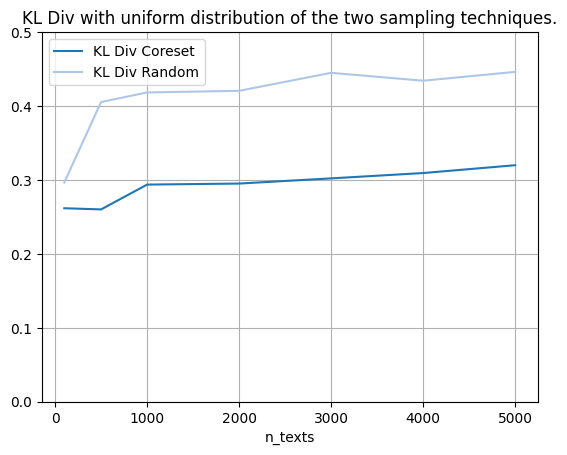

In [26]:
plt.plot(N_TEXTS, kl_divs_coreset, label="KL Div Coreset")
plt.plot(N_TEXTS, kl_divs_random, label="KL Div Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 0.5)
plt.grid()
plt.title('KL Div with uniform distribution of the two sampling techniques.')
plt.show()

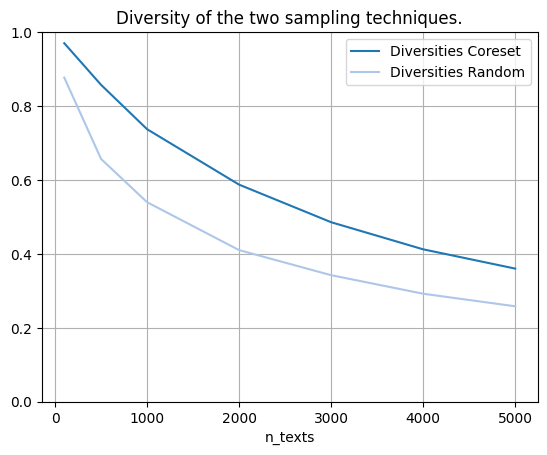

In [ ]:
plt.plot(N_TEXTS, diversities_coreset, label="Diversities Coreset")
plt.plot(N_TEXTS, diversities_random, label="Diversities Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.title('Diversity of the two sampling techniques.')
plt.show()

The metrics show that the sampled texts better captures the diversity of our dataset than random sampling, and are less biased by topic imbalance.

This is useful if your goal is to use a subset of wikipedia articles to finetune models.
A dataset sampled with coreset will provide more robustness for evaluation and more diversity of training.